## Imports

In [3]:
import nltk
from pathlib import Path
import pandas as pd
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

### Figure 3a

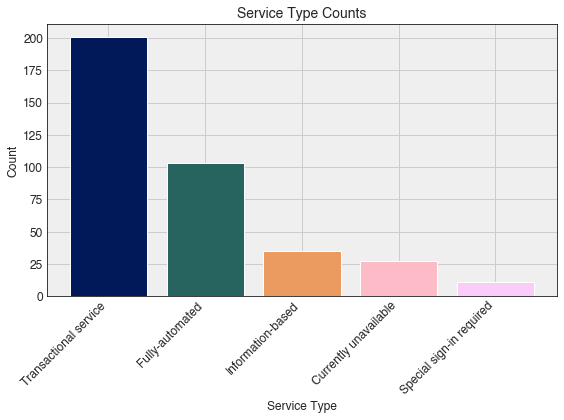

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_service_categories(save=False):
    """
    Load and plot service categories.
    """
    
    custom_palette = [
        '#011959',  '#27635f',
        '#eb9a60','#fdbac7', '#faccfa'
    ]
    
    # Load service data
    services_df = pd.read_pickle(Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl'))
    
    # Counting occurrences of each service_category
    service_counts = services_df['service_category'].value_counts()
    
    # Plotting the bar chart
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    ax = plt.subplot()
    
    # Selecting 5 colors from the custom palette
    colors = custom_palette[:5]
    
    # Plotting the bar chart with the selected colors from the custom palette
    bars = plt.bar(service_counts.index[:5], service_counts.values[:5], color=colors)  # Use only the first 5 values/colors
    
    # Setting the face color
    plt.gca().set_facecolor('#efefef')
    
    # Adding major and minor tick marks that point inwards
    plt.tick_params(axis='both', direction='in', length=6, width=1, which='major')
    plt.tick_params(axis='both', direction='in', length=4, width=1, which='minor')
    
    # Adding gridlines
    # plt.grid(True, linestyle='--', alpha=0.7)
    
    # Changing font size and rotation
    plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotating x-axis labels
    plt.yticks(fontsize=12)  # Setting y-axis labels font size
    
    # Adding labels and title
    plt.xlabel('Service Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Service Type Counts', fontsize=14)

    # Modify the spines
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_linewidth(.75)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(.75)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(.75)
    ax.spines['top'].set_linewidth(.75)
    ax.spines['bottom'].set_linewidth(.75)
    
    # Displaying the plot
    plt.tight_layout()
    
    # Save figure
    if save == True:
        plt.savefig(Path("../reports/figures/fig3a.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()


plot_service_categories(save=True);

### Figure 3b

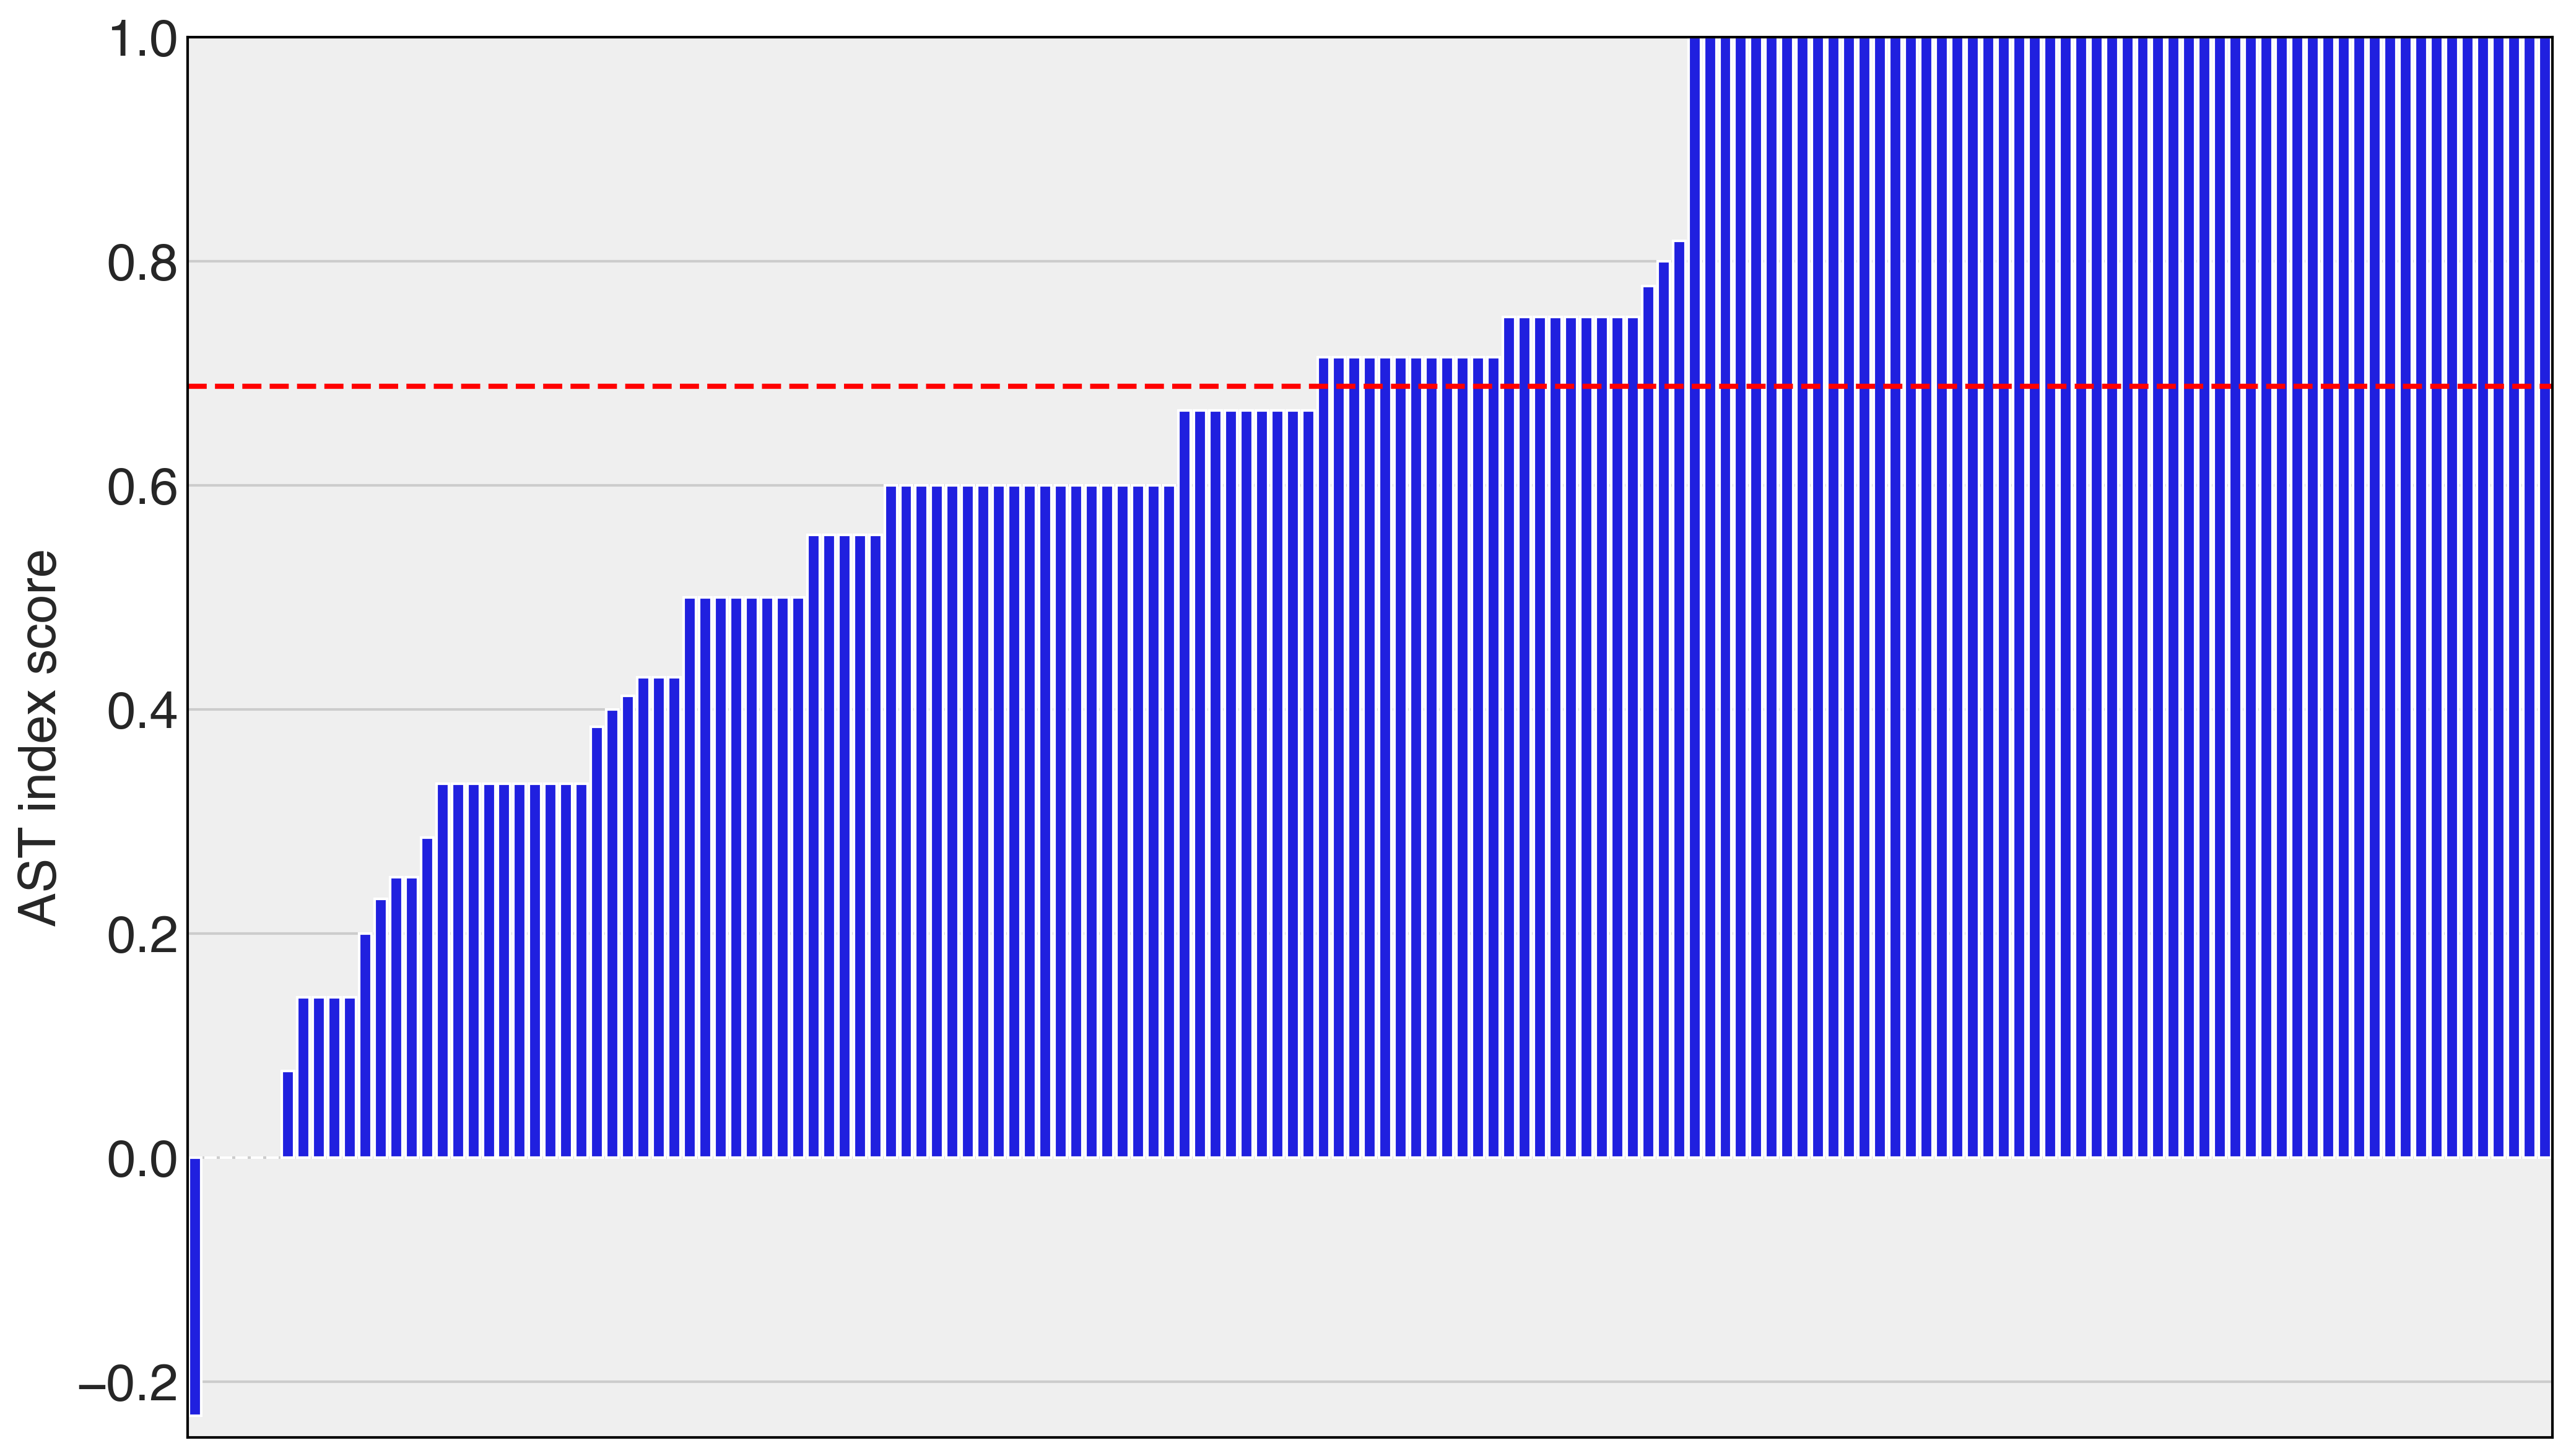

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_service_distribution(dataframe, metric='RTI_NRI', label='', xticks=True):
    # Set the style to match Nature/Science
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'Helvetica'
    plt.rcParams['font.size'] = 12  # Set font size

    # Sort the data
    sorted_data = dataframe.sort_values(by=metric)

    # Plotting
    plt.figure(figsize=(14, 8), dpi=300)
    ax = sns.barplot(data=sorted_data, x='service', y=metric, color='blue')

    plt.axhline(sorted_data[metric].mean(), color='red', linestyle='dashed', linewidth=2)
    plt.xlabel('')
    
    if metric == 'RTI_RC':
            plt.ylabel(metric[-2:] + ' score', fontsize=14)
    
    else:
        plt.ylabel(metric[-4:] + ' score', fontsize=14)
        
    plt.title(label, fontsize=16)
    ax.xaxis.set_tick_params(rotation=70)
    plt.xticks(fontsize=14)   

    if xticks == False:
        plt.xticks([])  

    plt.ylabel('AST index score', fontsize=20)
    
    plt.ylim(-.25,1)
    plt.yticks(fontsize=20)

    # Set face color
    plt.gca().set_facecolor('#efefef')

    # Adding major and minor tick marks that point inwards
    plt.tick_params(axis='both', direction='in', length=6, width=1, which='major')
    plt.tick_params(axis='both', direction='in', length=4, width=1, which='minor')

    # Modify the spines
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.tight_layout()
    plt.show()


analysis_df = pd.read_pickle('../data/processed/dataframes/analysis-df-w-api-data.pkl')

plot_service_distribution(
    analysis_df.loc[analysis_df['priority'] == False], 
    metric='RTI',  
    xticks=False)

### Figure 3c

### Figure 3d

In [65]:
    services_df = pd.read_pickle(Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl'))


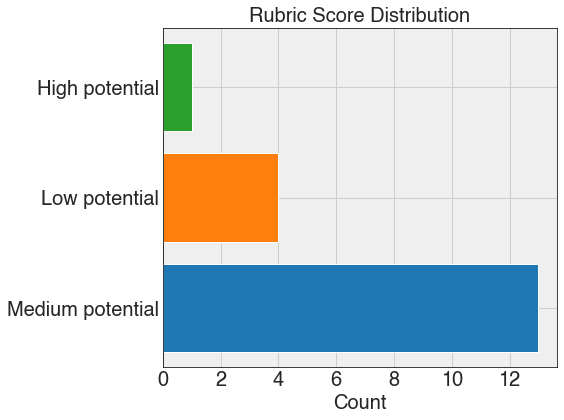

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_rubric_scores(save=False):
    """
    Load and plot rubric scores.
    """
    
    custom_palette = [
        '#011959', '#27635f',
        '#eb9a60', '#fdbac7', '#faccfa'
    ]
    
    # Load service data
    services_df = pd.read_pickle(Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl'))
    
    # Recoding x-axis values using the given dictionary
    recode_dict = {'LP': 'Low potential', 'MP': 'Medium potential', 'HP': 'High potential'}
    services_df['rubric_score_manual'] = services_df['rubric_score_manual'].map(recode_dict)
    
    # Counting occurrences of each rubric_score_manual
    service_counts = services_df['rubric_score_manual'].value_counts()
    
    # Plotting the bar chart horizontally
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    ax = plt.subplot()
    
    # Using a color palette (tab10) for the bar chart
    colors = plt.cm.tab10(range(len(service_counts)))
    
    # Plotting the bar chart horizontally with the color palette
    bars = plt.barh(service_counts.index, service_counts.values, color=colors)
    
    # Setting the face color
    plt.gca().set_facecolor('#efefef')
    
    # Adding major and minor tick marks that point inwards
    plt.tick_params(axis='both', direction='in', length=6, width=1, which='major')
    plt.tick_params(axis='both', direction='in', length=4, width=1, which='minor')
    
    # Changing font size
    plt.xticks(fontsize=20)  # Setting x-axis labels font size
    plt.yticks(fontsize=20)  # Setting y-axis labels font size
    
    # Adding labels and title
    plt.xlabel('Count', fontsize=20)
    plt.ylabel('', fontsize=20)
    plt.title('Rubric Score Distribution', fontsize=20)
    
    # Modify the spines
    for spine in ax.spines.values():
        spine.set_linewidth(.75)
        spine.set_color('black')
    
    # Displaying the plot
    plt.tight_layout()
    
    # Save figure
    if save:
        plt.savefig(Path("../reports/figures/fig3d.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()

plot_rubric_scores()

/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_59298/2234867078.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.1f}%'.format(x) for x in plt.gca().get_xticks()])  # Format x-axis ticks as percentages


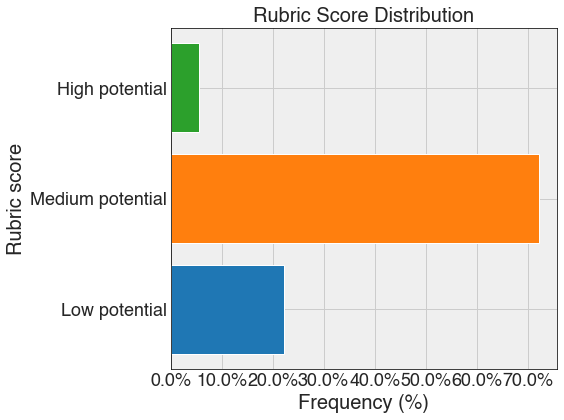

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_rubric_scores(save=False):
    """
    Load and plot rubric scores.
    """
    
    custom_palette = [
        '#011959', '#27635f',
        '#eb9a60', '#fdbac7', '#faccfa'
    ]
    
    # Load service data
    services_df = pd.read_pickle(Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl'))
    
    # Recoding x-axis values using the given dictionary
    recode_dict = {'LP': 'Low potential', 'MP': 'Medium potential', 'HP': 'High potential'}
    services_df['rubric_score_manual'] = services_df['rubric_score_manual'].map(recode_dict)
    
    # Specify the order of categories for the y-axis
    categories_order = ['Low potential', 'Medium potential', 'High potential']
    
    # Counting occurrences of each rubric_score_manual and arranging based on the specified order
    service_counts = services_df['rubric_score_manual'].value_counts(normalize=True).reindex(categories_order) * 100
    
    # Plotting the bar chart horizontally
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    ax = plt.subplot()
    
    # Using a color palette (tab10) for the bar chart
    colors = plt.cm.tab10(range(len(service_counts)))
    
    # Plotting the bar chart horizontally with the color palette
    bars = plt.barh(service_counts.index, service_counts.values, color=colors)
    
    # Setting the face color
    plt.gca().set_facecolor('#efefef')
    
    # Adding major and minor tick marks that point inwards
    plt.tick_params(axis='both', direction='in', length=6, width=1, which='major')
    plt.tick_params(axis='both', direction='in', length=4, width=1, which='minor')
    
    # Changing font size
    plt.xticks(fontsize=18)  # Setting x-axis labels font size
    plt.yticks(fontsize=18)  # Setting y-axis labels font size
    
    # Adding labels and title
    plt.xlabel('Frequency (%)', fontsize=20)
    plt.ylabel('Rubric score', fontsize=20)
    plt.title('Rubric Score Distribution', fontsize=20)
    
    # Modify the spines
    for spine in ax.spines.values():
        spine.set_linewidth(.75)
        spine.set_color('black')
    
    # Displaying the plot
    plt.tight_layout()
    
    # Update y-axis ticks to display percentages
    plt.gca().set_xticklabels(['{:,.1f}%'.format(x) for x in plt.gca().get_xticks()])  # Format x-axis ticks as percentages
    
    # Save figure
    if save:
        plt.savefig(Path("../reports/figures/fig3d.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()

plot_rubric_scores()